In [1]:
from __future__ import print_function
from __future__ import division
from builtins import map
import universe
from universe import *
import halo_fit
from halo_fit import *
import weight
from weight import *
import pn_2d
from pn_2d import *
import cmb
from cmb import *
import flat_map
from flat_map import *
import pandas as pd
import cmb_ilc
from cmb_ilc import *
import scipy

In [2]:
##################################################################################
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
# estimated from https://arxiv.org/pdf/1502.01585.pdf
#np.array([33.  , 23.  , 12.8]) * np.array([3224.4,  4331.0,  3358.5])**0.5 / 2.725

In [4]:
Nu_Planck =    [30.e9, 44.e9, 70.e9, 100.e9, 143.e9, 217.e9, 353.e9] # [Hz]
Beam_Planck =  [33.  , 23.  , 12.8 , 9.68  , 7.30  , 5.02  , 4.94  ] # FWHM [arcmin]
Noise_Planck = [688. , 555. , 272. , 77.4  , 33.   , 46.8  , 153.6 ] # [muK*arcmin]

Nu_SO =    [27.e9, 39.e9, 93.e9, 145.e9, 225.e9, 280.e9] # [Hz]
Beam_SO =  [7.4  , 5.1  , 2.2  , 1.4   , 1.0   , 0.9   ] # FWHM [arcmin]
Noise_SO = [52.  , 27.  , 5.8  , 6.3   , 15.   , 37.   ] # [muK*arcmin]

In [5]:
# SO
#Nu = np.array(Nu_SO) 
#Beam = np.array(Beam_SO)
#Noise = np.array(Noise_SO) 
#cmbIlc = CMBILC(Nu, Beam, Noise, atm=True)

In [6]:
# Planck 
Nu = np.array(Nu_Planck)
Beam = np.array(Beam_Planck)
Noise = np.array(Noise_Planck) 
cmbIlc = CMBILC(Nu, Beam, Noise, atm=False)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [7]:
def get_totals(l):
    wT = cmbIlc.weightsIlcCmb(l)
    wE = cmbIlc.weightsIlcCmbEE(l)
    Ctt = cmbIlc.powerIlc(wT, l)
    Cte = float(cmbIlc.cmb[0,0].ftotalTE(l))
    Cee = cmbIlc.powerIlcEE(wE, l)
    return np.array([l,Ctt,Cte,Cee])

In [8]:
ll = np.linspace(2,8000,2000)
res = []
for l in ll: res.append(get_totals(l))
res = np.array(res)

/home/noah/Berkeley/LensQuEst-1/cmb.py:116: RuntimeWarning: overflow encountered in double_scalars
  self.ftotalEE = lambda l: self.flensedEE(l) + 2.*self.fdetectorNoise(l)
/home/noah/Berkeley/LensQuEst-1/cmb.py:306: RuntimeWarning: overflow encountered in double_scalars
  return self.sensitivity**2 / self.fbeam(l)**2
/home/noah/Berkeley/LensQuEst-1/cmb.py:306: RuntimeWarning: divide by zero encountered in double_scalars
  return self.sensitivity**2 / self.fbeam(l)**2


In [37]:
from classy import Class

params = {
          'output': 'tCl lCl mPk pCl',
          'l_max_scalars': 8000,
          'lensing': 'yes',
          'P_k_max_h/Mpc': 10.,
          'non linear':'halofit', 
          'z_pk': '0.0,1087',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 1.0196,
          'N_ncdm': 2,
          'm_ncdm': '0.01,0.05',
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

cosmo = Class()   
cosmo.set(params) 
cosmo.compute()  

In [38]:
cls = cosmo.lensed_cl(8000)

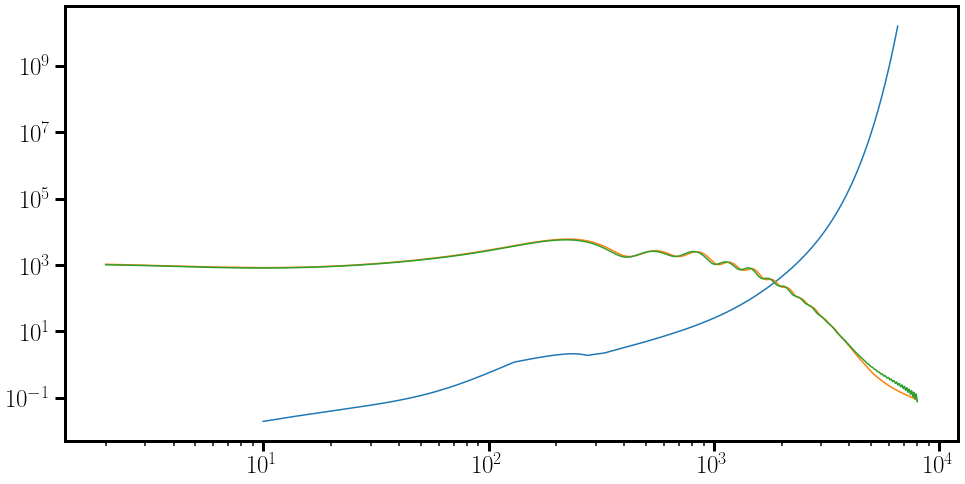

In [39]:
plt.figure(figsize=(16,8))

fac = res[:,0] * (res[:,0] + 1) / 2 / np.pi

Ctt_lens = cmbIlc.cmb[0,0].flensedTT(res[:,0])

plt.semilogy(res[:,0],fac * (res[:,1] - Ctt_lens) )
plt.semilogy(res[:,0],fac * Ctt_lens)

Tcmb = 2.725 * 1e6
plt.semilogx(cls['ell'][2:],cls['ell'][2:] * (cls['ell'][2:] + 1) * cls['tt'][2:] * Tcmb**2 / 2 / np.pi)

#plt.xlim(0,8000)
#plt.ylim(0.1,7e3)

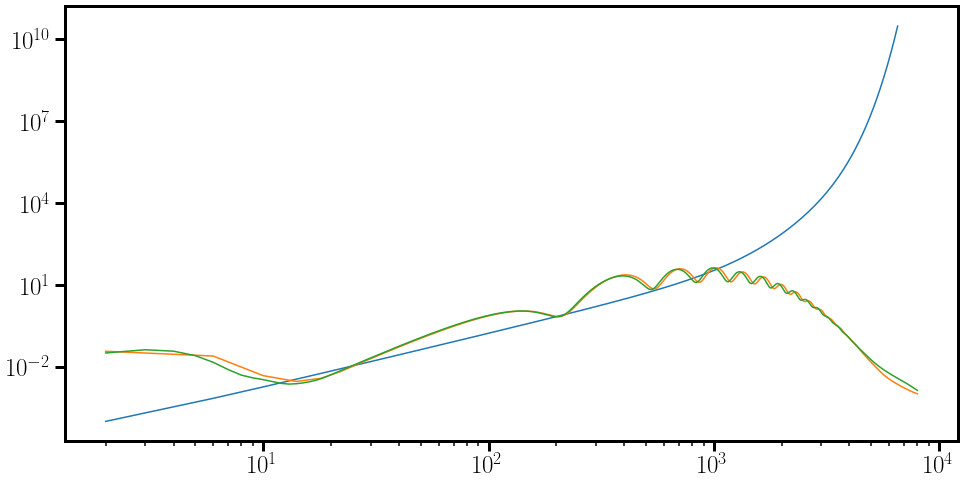

In [40]:
plt.figure(figsize=(16,8))

fac = res[:,0] * (res[:,0] + 1) / 2 / np.pi

Cee_lens = cmbIlc.cmb[0,0].flensedEE(res[:,0])

plt.semilogy(res[:,0],fac * (res[:,3] - Cee_lens) )
plt.semilogy(res[:,0],fac * Cee_lens)

Tcmb = 2.725 * 1e6
plt.semilogx(cls['ell'][2:],cls['ell'][2:] * (cls['ell'][2:] + 1) * cls['ee'][2:] * Tcmb**2 / 2 / np.pi)

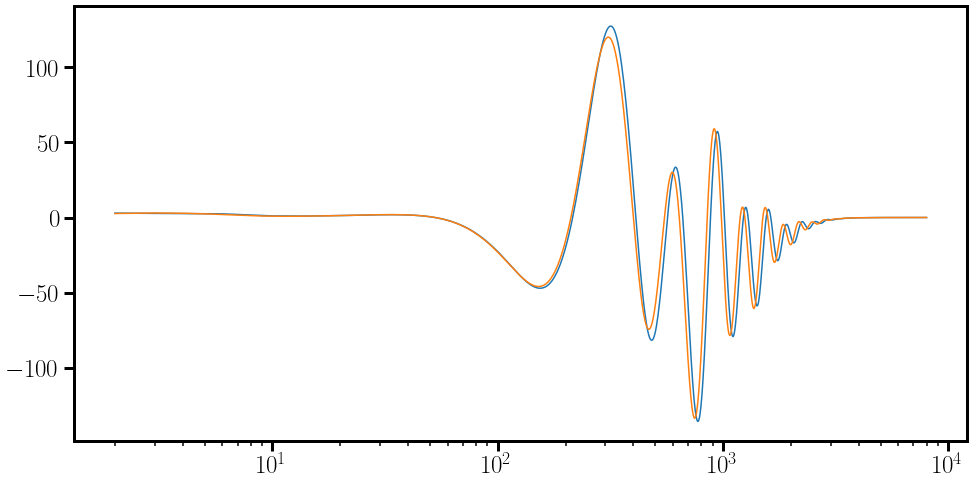

In [42]:
plt.figure(figsize=(16,8))

fac = res[:,0] * (res[:,0] + 1) / 2 / np.pi

Cte_lens = cmbIlc.cmb[0,0].flensedTE(res[:,0])

plt.plot(res[:,0],fac * Cte_lens)

plt.semilogx(cls['ell'][2:],cls['ell'][2:] * (cls['ell'][2:] + 1) * cls['te'][2:] * Tcmb**2 / 2 / np.pi)

In [12]:
np.savetxt('../fishlss/input/Planck_fiducial_TTTEEE.txt',res)